In [ ]:
# standard
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
# os
import os
# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Import btc
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Make pd df
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NN - 434/btc.csv')

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop extraneous columns
df.drop(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], axis = 1, inplace = True)
# Drop bottom 3m rows and top 800k
df.drop(df.index[:3000000], axis = 0, inplace = True)
df.drop(df.index[4000000:], axis = 0, inplace = True)
# Reset index; drop column
df.reset_index(drop = True, inplace = True)
# Backfill na's
df.fillna(method = 'backfill', inplace = True)

In [ ]:
# RNN target/features
features = ['Weighted_Price']
target = 'Weighted_Price'

In [ ]:
# Split train sets
train_weight = 0.8
df_split = int( len(df) * train_weight )

train = df.iloc[:df_split]
test = df.iloc[df_split:]

In [ ]:
# Scaling parameters
mu = float( train[features].mean() )
sigma = float( train[features].std() )

# Scale data
train_n = train[features].apply( lambda x: (x - mu) / sigma )
test_n = test[features].apply( lambda x: (x - mu) / sigma )

/root/.local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


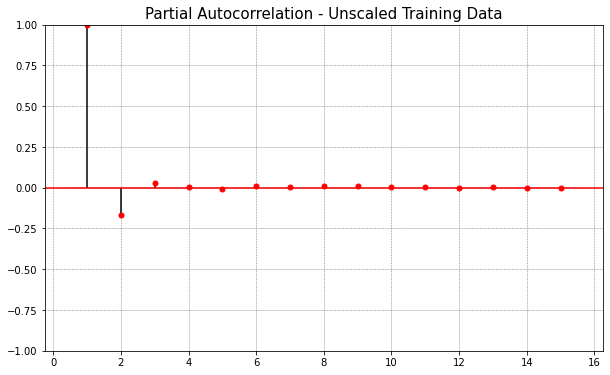

In [ ]:
# Partial autocorrelation of unscaled data
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,6))

plot_pacf(train[:200000], lags = 15, alpha = 0.05, zero = False, color = 'red', ax = ax)
plt.title('Partial Autocorrelation - Unscaled Training Data', fontsize = 15)
plt.grid(which = 'major', color = 'grey', linestyle = '--', linewidth = 0.5)

plt.show()

/root/.local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


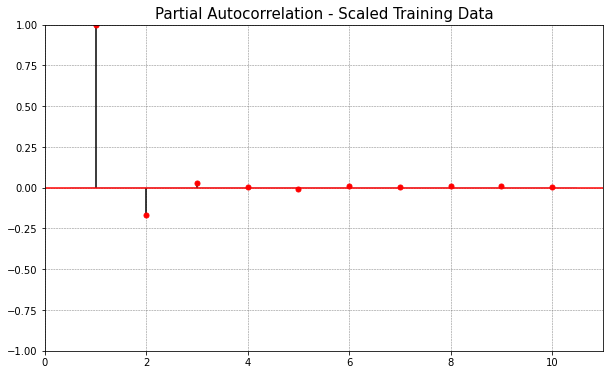

In [ ]:
# Partial autocorrelation of scaled data
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,6))

plot_pacf(train_n[:200000], lags = 10, alpha = 0.05, zero = False, color = 'red', ax = ax)
plt.title('Partial Autocorrelation - Scaled Training Data', fontsize = 15)
plt.grid(which = 'major', color = 'grey', linestyle = '--', linewidth = 0.5)

plt.show()

In [ ]:
# Standard models
def _ARIMA(train = train_n, p = 3, d = 0, q = 0):
    return ARIMA(endog = train, order = (p, d, q), enforce_stationarity = False)

In [ ]:
# Standard model evaluation functions
def evaluate_ARIMA(data = train_n, p_val = 3, d_val = 0, q_val = 0):
    start_indices = np.random.randint(low = 0, high = len(train) - 200, size = 30)
    aic = list()

    for i in start_indices:
        data_slice = data[i : i + 100]
        model = _ARIMA(data_slice, p_val, d_val, q_val).fit()
        aic.append(model.aic)

    return np.mean(aic), model

In [ ]:
# Standard models
standards = {
    'arima': {'model':'', 'function':_ARIMA, 'p':3, 'd':0, 'q':0, 'train':train_n, 'color':'green', 'label':'ARIMA', 'fitted':''}
}

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Cross-validate ARIMA
best_aic = 0
best_order = (0, 0, 0)
best_model = ''

for p in [1, 3, 5, 7]:
    for d in [0, 1, 2]:
        for q in [0, 1, 2]:
            #try:
                aic, mod = evaluate_ARIMA(train_n, p, d, q)
                print("Order: (%d, %d, %d), Mean AIC: [ %f ]" % (p, d, q, aic))
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = mod
            #except:
                #continue

standards['arima']['p'], standards['arima']['d'], standards['arima']['q'] = best_order[0], best_order[1], best_order[2]
standards['arima']['fitted'] = best_model

print("Best ARIMA configuration: AIC [ %f ], order %s" % (best_aic, str(best_order)) )
print(best_model.summary())

Order: (1, 0, 0), Mean AIC: [ -878.686200 ]
Order: (1, 0, 1), Mean AIC: [ -891.035905 ]
Order: (1, 0, 2), Mean AIC: [ -915.825556 ]
Order: (1, 1, 0), Mean AIC: [ -913.192431 ]
Order: (1, 1, 1), Mean AIC: [ -901.011351 ]
Order: (1, 1, 2), Mean AIC: [ -909.407235 ]
Order: (1, 2, 0), Mean AIC: [ -877.223237 ]
Order: (1, 2, 1), Mean AIC: [ -892.976336 ]
Order: (1, 2, 2), Mean AIC: [ -820.005281 ]
Order: (3, 0, 0), Mean AIC: [ -972.893757 ]
Order: (3, 0, 1), Mean AIC: [ -864.724963 ]
Order: (3, 0, 2), Mean AIC: [ -916.635911 ]
Order: (3, 1, 0), Mean AIC: [ -927.730713 ]
Order: (3, 1, 1), Mean AIC: [ -881.046161 ]
Order: (3, 1, 2), Mean AIC: [ -850.723003 ]
Order: (3, 2, 0), Mean AIC: [ -877.635594 ]
Order: (3, 2, 1), Mean AIC: [ -925.399616 ]
Order: (3, 2, 2), Mean AIC: [ -835.171975 ]
Order: (5, 0, 0), Mean AIC: [ -877.225663 ]
Order: (5, 0, 1), Mean AIC: [ -864.802407 ]
Order: (5, 0, 2), Mean AIC: [ -820.763346 ]
Order: (5, 1, 0), Mean AIC: [ -847.039619 ]
Order: (5, 1, 1), Mean AIC: [ -8

In [ ]:
# Iterative walk-forward validation
n_iter = 50
window = 100

p, d, q = best_order[0], best_order[1], best_order[2]

print('Walk Forward Validation Using Optimized Parameters:')

residuals = list()
errors = list()

indices = np.random.randint(low = 200, high = len(train) - 200, size = n_iter)
i = 1

for j in indices:
    fit_partition = np.array( train_n['Weighted_Price'][j - window : j] )
    validation_partition = np.array( train_n['Weighted_Price'][j: j + window] )
    model = _ARIMA(fit_partition, p, d, q).fit()
    pred = model.forecast(steps = window)
    residual = pred[0] - validation_partition
    squared_errors = [ np.square(x) * np.sign(x) for x in residual ]
    residuals.append(residual)
    errors.append(squared_errors)
    print('   Iteration ' + str(i) + ': mean MSE [ ' + str( np.mean(squared_errors) ) + ' ]')

    i += 1

Walk Forward Validation Using Optimized Parameters:
   Iteration 1: mean MSE [ -0.0007810617427591083 ]
   Iteration 2: mean MSE [ 3.234796204032008e-05 ]
   Iteration 3: mean MSE [ 0.0002980799725194318 ]
   Iteration 4: mean MSE [ 2.93897019408842e-05 ]
   Iteration 5: mean MSE [ 4.4352354973352895e-05 ]
   Iteration 6: mean MSE [ -0.005878727324443802 ]
   Iteration 7: mean MSE [ 8.794491487980655e-05 ]
   Iteration 8: mean MSE [ -1.618340816953099e-05 ]
   Iteration 9: mean MSE [ 0.0002360694317313613 ]
   Iteration 10: mean MSE [ -0.002588457433254409 ]
   Iteration 11: mean MSE [ 0.010118470322178871 ]
   Iteration 12: mean MSE [ 8.694325927687129e-05 ]
   Iteration 13: mean MSE [ 3.0050380483336557e-05 ]
   Iteration 14: mean MSE [ 0.0030245757377667976 ]
   Iteration 15: mean MSE [ 2.4238969889530335e-06 ]
   Iteration 16: mean MSE [ 0.00010922632363596534 ]
   Iteration 17: mean MSE [ -0.0001757987151418833 ]
   Iteration 18: mean MSE [ -0.0002437882079369641 ]
   Iteration 19

In [ ]:
# Calculate mean error
mean_MSE = np.mean(np.array(errors), axis = 0)
mean_residuals = np.mean(np.array(residuals), axis = 0)

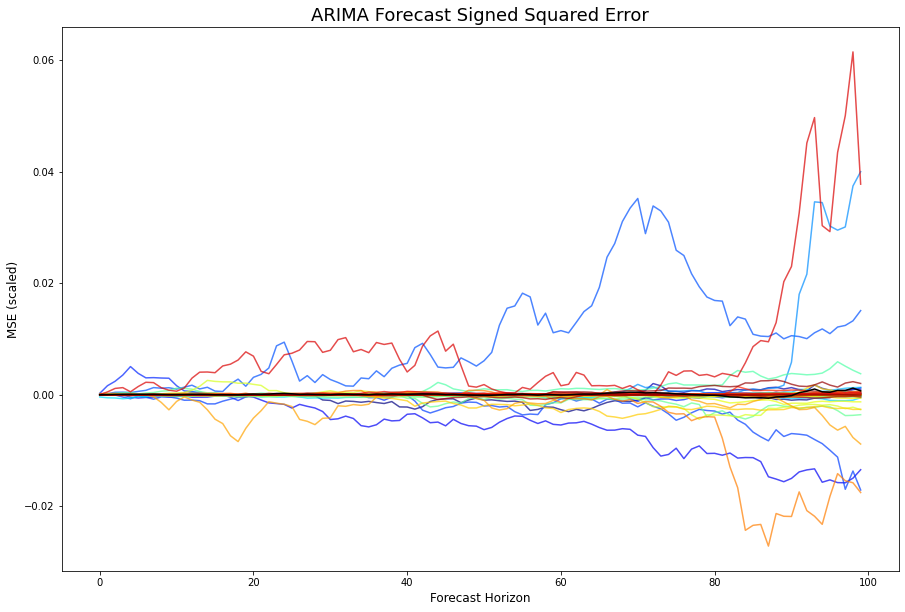

In [ ]:
# Plot MSE
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, window)

colors = pl.cm.jet(np.linspace(0, 1, n_iter))

for i in range(0, n_iter):
    plt.plot(_x, errors[i], color = colors[i], alpha = 0.7)

plt.plot(_x, mean_MSE, color = 'black')

plt.title('ARIMA Forecast Signed Squared Error', fontsize = 18)
plt.xlabel('Forecast Horizon', fontsize = 12)
plt.ylabel('MSE (scaled)', fontsize = 12)

plt.show()

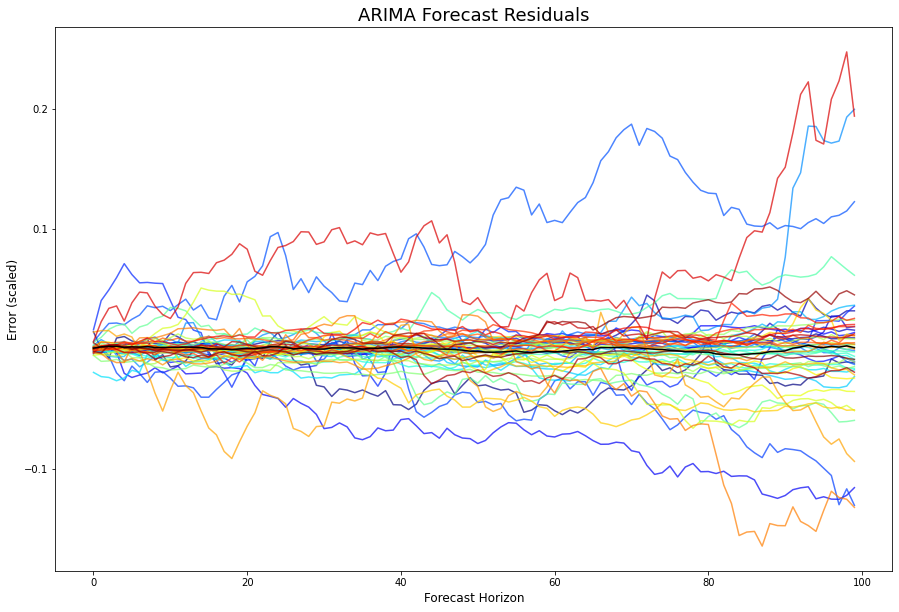

In [ ]:
# Plot residuals
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, window)

colors = pl.cm.jet(np.linspace(0, 1, n_iter))

for i in range(0, n_iter):
    plt.plot(_x, residuals[i], color = colors[i], alpha = 0.7)

plt.plot(_x, mean_residuals, color = 'black')

plt.title('ARIMA Forecast Residuals', fontsize = 18)
plt.xlabel('Forecast Horizon', fontsize = 12)
plt.ylabel('Error (scaled)', fontsize = 12)

plt.show()

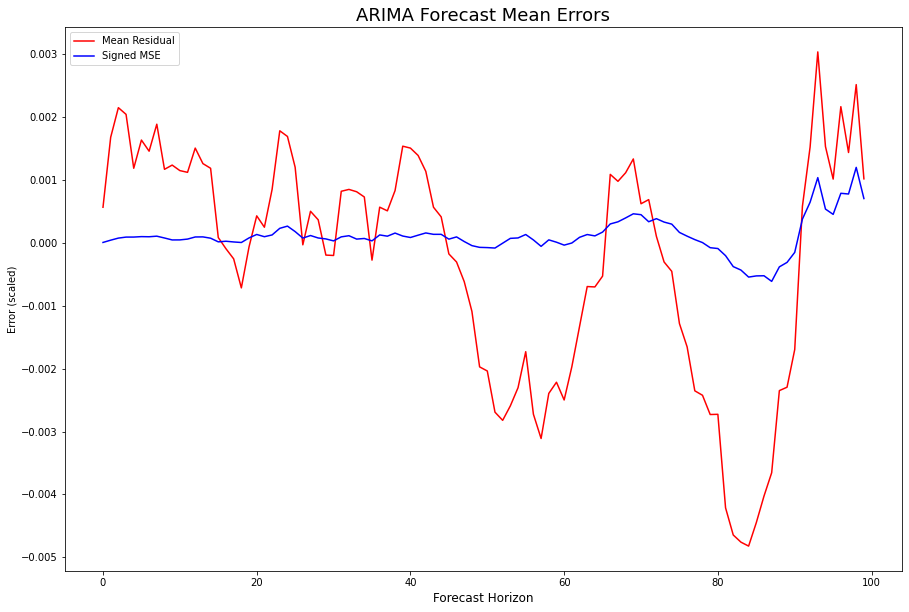

In [ ]:
# Mean signed MSE and Residuals
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, window)

plt.plot(_x, mean_residuals, color = 'red', label = 'Mean Residual')
plt.plot(_x, mean_MSE, color = 'blue', label = 'Signed MSE')

plt.title('ARIMA Forecast Mean Errors', fontsize = 18)
plt.legend(loc = 'best')
plt.xlabel('Forecast Horizon', fontsize = 12)
plt.ylabel('Error (scaled)')

plt.show()

In [ ]:
# Raw outputs

print('ARIMA Forecast Errors')
print()
print('Time\t\tResidual\t\tSigned MSE')

for i in range(0, window):
    print('t + %d\t\t%.6f\t\t%.6f' % ((i+1), mean_residuals[i], mean_MSE[i]))

ARIMA Forecast Errors

Time		Residual		Signed MSE
t + 1		0.000565		0.000006
t + 2		0.001677		0.000042
t + 3		0.002148		0.000075
t + 4		0.002041		0.000091
t + 5		0.001185		0.000091
t + 6		0.001633		0.000098
t + 7		0.001456		0.000096
t + 8		0.001885		0.000105
t + 9		0.001168		0.000076
t + 10		0.001235		0.000046
t + 11		0.001148		0.000046
t + 12		0.001120		0.000059
t + 13		0.001505		0.000093
t + 14		0.001259		0.000094
t + 15		0.001184		0.000073
t + 16		0.000083		0.000015
t + 17		-0.000094		0.000025
t + 18		-0.000255		0.000013
t + 19		-0.000716		0.000005
t + 20		-0.000065		0.000078
t + 21		0.000428		0.000133
t + 22		0.000248		0.000097
t + 23		0.000848		0.000125
t + 24		0.001780		0.000230
t + 25		0.001690		0.000265
t + 26		0.001201		0.000178
t + 27		-0.000032		0.000075
t + 28		0.000501		0.000116
t + 29		0.000366		0.000077
t + 30		-0.000195		0.000062
t + 31		-0.000201		0.000030
t + 32		0.000819		0.000095
t + 33		0.000849		0.000113
t + 34		0.000812		0.000059
t + 35		0.000728		0.000069
t + 36	